PyTorchによる画像分類の学習

[PyTorchチュートリアル（日本語翻訳版）](https://yutaroogawa.github.io/pytorch_tutorials_jp/)の[画像分類タスクに対する転移学習の方法](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/2_Image_Video/2_1_transfer_learning_tutorial_jp.ipynb)を調べながら実施

その他参考： [日本絵画に描かれた人物の顔分類に機械学習で挑戦！ - チュートリアル](https://www.nishika.com/competitions/5/topics/34)

In [1]:
import os
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as tcdata

from torchvision import transforms, models

from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(torch.__version__)

1.12.1


In [2]:
image_path = os.path.join('data', 'hymenoptera_data_modified', 'images')    # 画像が入っているフォルダ
print(image_path)
csv_path = os.path.join('data', 'hymenoptera_data_modified', 'data.csv')    #  画像ファイル名やターゲットのcsv
print(csv_path)

data/hymenoptera_data_modified/images
data/hymenoptera_data_modified/data.csv


## 画像の確認

In [3]:
# 画像のサイズ確認
'''
img_list = pd.read_csv(csv_path)['images']

for jpg in img_list:
    im = Image.open(os.path.join(image_path, jpg))
    print(np.array(im).shape, jpg)
'''

"\nimg_list = pd.read_csv(csv_path)['images']\n\nfor jpg in img_list:\n    im = Image.open(os.path.join(image_path, jpg))\n    print(np.array(im).shape, jpg)\n"

In [4]:
!ls data/hymenoptera_data_modified/images | head -n5

0013035.jpg
1030023514_aad5c608f9.jpg
10308379_1b6c72e180.jpg
1032546534_06907fe3b3.jpg
1053149811_f62a3410d3.jpg


<class 'PIL.JpegImagePlugin.JpegImageFile'>
(375, 500, 3)


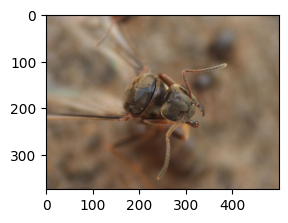

In [5]:
## 画像の確認
sample_image = os.path.join(image_path, '1053149811_f62a3410d3.jpg')

img = Image.open(sample_image)
print(type(img))
print(np.array(img).shape)    # numpyに変換し、次元の確認

plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.show()

## メタデータ（画像のパスやターゲット情報）の確認と処理

In [6]:
df_metadata = pd.read_csv(csv_path)
print(df_metadata.shape)
df_metadata.head()

(397, 3)


,images,train_val,target
0,10308379_1b6c72e180.jpg,val,ants
1,1053149811_f62a3410d3.jpg,val,ants
2,1073564163_225a64f170.jpg,val,ants
3,1119630822_cd325ea21a.jpg,val,ants
4,1124525276_816a07c17f.jpg,val,ants


In [7]:
# ターゲット変数をintに変換 ants->0, bees->1
df_metadata['target_int'] = df_metadata['target'].map({'ants':0, 'bees':1})
display(df_metadata.head())

# 学習(train), 検証(val)に分割
df_train = df_metadata[df_metadata['train_val']=='train'].reset_index(drop=True)
df_val = df_metadata[df_metadata['train_val']=='val'].reset_index(drop=True)
df_train.shape, df_val.shape

,images,train_val,target,target_int
0,10308379_1b6c72e180.jpg,val,ants,0
1,1053149811_f62a3410d3.jpg,val,ants,0
2,1073564163_225a64f170.jpg,val,ants,0
3,1119630822_cd325ea21a.jpg,val,ants,0
4,1124525276_816a07c17f.jpg,val,ants,0


((244, 4), (153, 4))

## 画像の前処理（学習時にはデータ拡張を機能）

画像前処理の例：[ILLUSTRATION OF TRANSFORMS](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html)

In [8]:
## データ拡張の機能
image_transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),     # meanを引いてstdで割る 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

Normalizeの値に関して：[PyTorch における正規化について](https://teratail.com/questions/295871)  
Resizeの値に関して：[Resnet 画像サイズが224×224以外の場合の処理](https://teratail.com/questions/337256)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
-----
<class 'torch.Tensor'>
torch.Size([3, 224, 224])
-----
<class 'numpy.ndarray'>
(224, 224, 3)
最小最大：  -1.6855742 2.1659663
最小最大：  0.0 1.0


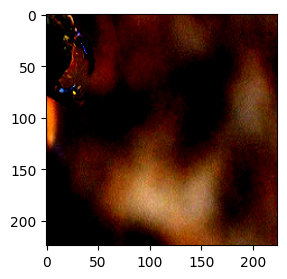

In [9]:
# 画像にデータ処理を試してみる

print(type(img))

print('-----')

transformed_sample = image_transform['train'](img)     # image_transform['train']に適用
print(type(transformed_sample))
print(transformed_sample.size())

print('-----')

transformed_sample = transformed_sample.numpy().transpose((1, 2, 0))
print(type(transformed_sample))
print(transformed_sample.shape)
print('最小最大： ', transformed_sample.min(), transformed_sample.max())
transformed_sample = np.clip(transformed_sample, 0, 1)    # 0以下の値は0、1以上は1に置き換える。plt.imshowの仕様であって、学習時には実施しない
print('最小最大： ', transformed_sample.min(), transformed_sample.max())

plt.figure(figsize=(3, 3))
plt.imshow(transformed_sample)
plt.show()

## DatasetとDataloader
[PyTorch入門 2. データセットとデータローダー](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/0_Learn%20the%20Basics/0_2_data_tutorial_jp.ipynb)

In [10]:
## カスタムDatasetの作成
class ImageDataset(tcdata.Dataset):
    def __init__(self, dataframe, image_dir, image_tansforem):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.image_tansforem = image_tansforem     # データ拡張の機能
    
    def __len__(self):
        return self.dataframe.shape[0]      # データの行数
    
    def __getitem__(self, idx):
        '''
        (torch.Tensor, 数値)型で1オブザベーションのインプット画像とターゲットを返す
        '''
        image_file = os.path.join(image_path, df_train.loc[idx, 'images'])    # 画像のパス。'data/hymenoptera_data_modified/images0013035.jpg'など
        img = Image.open(image_file)
        img = self.image_tansforem(img)
        tgt = self.dataframe.loc[idx, 'target_int']
        return img, tgt
    

In [11]:
## 学習(train), 検証(val)別でImageDatasetインスタンスを作成

train_data = ImageDataset(dataframe=df_train, 
                                                image_dir=image_path, 
                                                image_tansforem=image_transform['train'])
val_data = ImageDataset(dataframe=df_val, 
                                             image_dir=image_path, 
                                             image_tansforem=image_transform['val'])

In [12]:
# 値を入れ検証
print(train_data[13])     # (torch.Tensor, int)型でデータが返っている
print(train_data[13][0].size())      # 前処理が実施された画像の次元数

(tensor([[[-0.1999, -0.1999, -0.1999,  ..., -0.6623, -0.6109, -0.5424],
         [-0.1143, -0.1486, -0.1828,  ..., -0.6794, -0.6281, -0.5596],
         [-0.0801, -0.1486, -0.1999,  ..., -0.6794, -0.6452, -0.5938],
         ...,
         [-0.4397, -0.4397, -0.4397,  ..., -0.6452, -0.5938, -0.5767],
         [-0.4397, -0.4397, -0.4739,  ..., -0.6281, -0.5767, -0.5596],
         [-0.4226, -0.4568, -0.4911,  ..., -0.6281, -0.5767, -0.5424]],

        [[ 1.2731,  1.2906,  1.3081,  ...,  1.0805,  1.1506,  1.2031],
         [ 1.3782,  1.3431,  1.2906,  ...,  1.0455,  1.0805,  1.1331],
         [ 1.4482,  1.3606,  1.2556,  ...,  0.9930,  1.0105,  1.0455],
         ...,
         [ 1.2031,  1.2206,  1.2556,  ...,  0.9930,  1.0105,  1.0280],
         [ 1.2381,  1.2556,  1.2556,  ...,  0.9930,  1.0280,  1.0455],
         [ 1.2906,  1.2906,  1.2731,  ...,  0.9930,  1.0105,  1.0280]],

        [[-0.1487, -0.0441,  0.0605,  ..., -0.6541, -0.6193, -0.5844],
         [ 0.0082,  0.0605,  0.1302,  ..., -

In [13]:
## Dataloderを作成

batch_size = 12    # バッチサイズ

train_dataloder = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_dataloder = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

In [14]:
# 動作検証
iter_train_dataloder = iter(train_dataloder)
inputs, labels = next(iter_train_dataloder)
print(type(inputs))
print(inputs.size())    # Batch, Channel, Height, Width
print(type(labels))
print(labels)    # バッチ数分の正解ラベル

<class 'torch.Tensor'>
torch.Size([12, 3, 224, 224])
<class 'torch.Tensor'>
tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1])


In [15]:
labels.device

device(type='cpu')

## モデル定義

In [16]:
## ResNet18 事前学習モデルのロード
net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
type(net)

torchvision.models.resnet.ResNet

In [17]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# パラメータ名と次元数、required_gradsを確認してみる
for name, param in net.named_parameters():
    print('[Param Name] {}  |  [Size] {}  |  [requires_grad（勾配計算の実施有無）] {}'.format(name, param.size(), param.requires_grad))

# パラメータのみにアクセスする場合はnet.parameters()

[Param Name] conv1.weight  |  [Size] torch.Size([64, 3, 7, 7])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] bn1.weight  |  [Size] torch.Size([64])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] bn1.bias  |  [Size] torch.Size([64])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] layer1.0.conv1.weight  |  [Size] torch.Size([64, 64, 3, 3])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] layer1.0.bn1.weight  |  [Size] torch.Size([64])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] layer1.0.bn1.bias  |  [Size] torch.Size([64])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] layer1.0.conv2.weight  |  [Size] torch.Size([64, 64, 3, 3])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] layer1.0.bn2.weight  |  [Size] torch.Size([64])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] layer1.0.bn2.bias  |  [Size] torch.Size([64])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] layer1.1.conv1.weight  |  [Size] torch.Size([64, 64, 3, 3])  |  [requires_grad（勾配計算の実施有無）] True
[Param Name] lay

In [19]:
# 個別のモジュールにアクセスする場合
print(net.fc)
print(net.fc.in_features)    # その層の設定の取得

Linear(in_features=512, out_features=1000, bias=True)
512


In [20]:
## パラメータ（重み、バイアス）を確認すると学習済みモデルの値が確認できる
#[i for i in net.fc.named_parameters()]    # 長いので省略

In [21]:
# Sequentialで定義されているモジュールの場合
print(net.layer1)

print('~~~~~~ 中のモジュールへのアクセス ~~~~~~')
print(net.layer1[0].conv1)
print(net.layer1[0].conv1.in_channels, net.layer1[0].conv1.out_channels)    # その層の設定の取得

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
~~~~~~ 中のモジュールへのアクセス ~~~~~~
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
64 64


### ファインチューニング or 転移学習（特徴量抽出器）

#### ファインチューニングの場合

In [22]:
# アウトプットの次元数のみ変更

# Step1: モデルインスタンスの作成
net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

print('全結合層のアウトプットの次元数：{}'.format(net.fc.out_features))

# Step2: 全結合層のアウトプットの次元数を置き換える
net.fc = torch.nn.Linear(net.fc.in_features, 2)    # antsとbeesの二値分類
print('変更後の全結合層のアウトプットの次元数：{}'.format(net.fc.out_features))
net.fc    # 全結合層

全結合層のアウトプットの次元数：1000
変更後の全結合層のアウトプットの次元数：2


Linear(in_features=512, out_features=2, bias=True)

In [23]:
# パラメータのrequired_gradsを確認してみる
[(name, param.requires_grad) for name, param in net.named_parameters()]

[('conv1.weight', True),
 ('bn1.weight', True),
 ('bn1.bias', True),
 ('layer1.0.conv1.weight', True),
 ('layer1.0.bn1.weight', True),
 ('layer1.0.bn1.bias', True),
 ('layer1.0.conv2.weight', True),
 ('layer1.0.bn2.weight', True),
 ('layer1.0.bn2.bias', True),
 ('layer1.1.conv1.weight', True),
 ('layer1.1.bn1.weight', True),
 ('layer1.1.bn1.bias', True),
 ('layer1.1.conv2.weight', True),
 ('layer1.1.bn2.weight', True),
 ('layer1.1.bn2.bias', True),
 ('layer2.0.conv1.weight', True),
 ('layer2.0.bn1.weight', True),
 ('layer2.0.bn1.bias', True),
 ('layer2.0.conv2.weight', True),
 ('layer2.0.bn2.weight', True),
 ('layer2.0.bn2.bias', True),
 ('layer2.0.downsample.0.weight', True),
 ('layer2.0.downsample.1.weight', True),
 ('layer2.0.downsample.1.bias', True),
 ('layer2.1.conv1.weight', True),
 ('layer2.1.bn1.weight', True),
 ('layer2.1.bn1.bias', True),
 ('layer2.1.conv2.weight', True),
 ('layer2.1.bn2.weight', True),
 ('layer2.1.bn2.bias', True),
 ('layer3.0.conv1.weight', True),
 ('layer

#### 転移学習（特徴量抽出器）の場合

In [24]:
# アウトプットの次元数のみ変更

# Step1: モデルインスタンスの作成
net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Step2: 勾配計算をOffにする
for param in net.parameters():
    param.requires_grad = False     # 一旦全てのパラメータのrequired_gradをFalseとし、loss.backward()で勾配が計算されないようにする

print('全結合層のアウトプットの次元数：{}'.format(net.fc.out_features))

# Step3: 全結合層のアウトプットの次元数を置き換える
# 置き換えた層のequired_gradはとなる
net.fc = torch.nn.Linear(net.fc.in_features, 2)    # antsとbeesの二値分類
print('変更後の全結合層のアウトプットの次元数：{}'.format(net.fc.out_features))
net.fc    # 全結合層

全結合層のアウトプットの次元数：1000
変更後の全結合層のアウトプットの次元数：2


Linear(in_features=512, out_features=2, bias=True)

In [25]:
# パラメータのrequired_gradsを確認してみる
# 全結合層のみTrue
[(name, param.requires_grad) for name, param in net.named_parameters()]

[('conv1.weight', False),
 ('bn1.weight', False),
 ('bn1.bias', False),
 ('layer1.0.conv1.weight', False),
 ('layer1.0.bn1.weight', False),
 ('layer1.0.bn1.bias', False),
 ('layer1.0.conv2.weight', False),
 ('layer1.0.bn2.weight', False),
 ('layer1.0.bn2.bias', False),
 ('layer1.1.conv1.weight', False),
 ('layer1.1.bn1.weight', False),
 ('layer1.1.bn1.bias', False),
 ('layer1.1.conv2.weight', False),
 ('layer1.1.bn2.weight', False),
 ('layer1.1.bn2.bias', False),
 ('layer2.0.conv1.weight', False),
 ('layer2.0.bn1.weight', False),
 ('layer2.0.bn1.bias', False),
 ('layer2.0.conv2.weight', False),
 ('layer2.0.bn2.weight', False),
 ('layer2.0.bn2.bias', False),
 ('layer2.0.downsample.0.weight', False),
 ('layer2.0.downsample.1.weight', False),
 ('layer2.0.downsample.1.bias', False),
 ('layer2.1.conv1.weight', False),
 ('layer2.1.bn1.weight', False),
 ('layer2.1.bn1.bias', False),
 ('layer2.1.conv2.weight', False),
 ('layer2.1.bn2.weight', False),
 ('layer2.1.bn2.bias', False),
 ('layer3.0.

In [26]:
# 比較のために、学習前のパラメータを取得しておく

# conv1層
conv1_not_trained_param = copy.deepcopy([i for i in net.conv1.parameters()])

# fc層
fc_not_trained_param = copy.deepcopy([i for i in net.fc.parameters()])

## モデル学習

#### 学習実行用の関数を作成
ループ構造  
`
ループ（エポック）
    ループ（train/val）
        ループ（ミニバッチ）
`

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, device, train_dataloder, val_dataloder, train_ndata, val_ndata):
    '''
    '''
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())    # ベストモデルの重みの保存用
    best_acc = 0.0   # ベストモデルの正解率
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-----------------')
        
        for phase in ['train', 'val']:
            if phase == 'train':
                print('>> train phase')
                model.train()  # モデルを訓練モードに設定
                dataloder = train_dataloder    # Dataloderは学習データ用
                ndata = train_ndata   # 訓練データの行数
            else:
                print('>> val phase')
                model.eval()  # モデルを評価モードに設定
                dataloder = val_dataloder        # Dataloderは検証データ用
                ndata = val_ndata     # 検証データの行数
            
            running_loss = 0.0          # 損失の途中計算用
            running_corrects = 0      # Accuracyの途中計算用（正解数を格納）
            
            # ミニバッチのループ
            for inputs, labels in dataloder:
                #print(inputs.size(), labels.size())
                
                #print(inputs.device, labels.device)    # deviceの確認
                inputs = inputs.to(device)    # データをdeviceに送る（GPUを利用する場合）
                labels = labels.to(device)
                #print(inputs.device, labels.device)    # deviceの確認。GPUとなったか
                
                optimizer.zero_grad()    # モデルパラメータの勾配をリセット
                
                with torch.set_grad_enabled(phase == 'train'):   # trainの時、torch.set_grad_enabledにTrueを渡し、勾配計算が実施される
                    # 順伝播
                    outputs = model(inputs)   # 予測値の取得
                    loss = criterion(outputs, labels)      # ミニバッチの損失
                    _, preds = torch.max(outputs, 1)   #　ミニバッチ各データの予測ラベル（0 or 1）を取得（最大値の要素の位置）
                    
                    if phase == 'train':
                        loss.backward()    # 逆伝搬（勾配計算）
                        optimizer.step()   # パラメータ更新
                
                # ミニバッチの予測結果を積み上げる
                running_loss += loss.item() * inputs.size(0)    # 損失
                running_corrects += torch.sum(preds == labels.data)     # 正解数
                
                #print('~~~ ミニバッチ終了 ~~~')
                
            if phase == 'train':
                scheduler.step()      # ??????? エポックが終了した際、lrの変更を確認？？
            
            epoch_loss = running_loss / ndata     # エポックにおける損失
            epoch_acc = running_corrects.double() / ndata   # エポックにおける正解率
            print('{} Loss: {:.4f} Accuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:    # エポックにおいて検証精度が過去のエポックの結果を超えるとベストモデルをアップデート
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print('~~~~~ エポック終了 ~~~~~')
        
    time_elapsed = time.time() - since
    print('学習時間: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('ベストな検証Accuracy: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)    # ベストモデルの重みをロード
    

`with torch.set_grad_enabled(phase == 'train')`[に関して](https://axa.biopapyrus.jp/deep-learning/object-classification/tensor-autograd.html)  
`_, preds = torch.max(outputs, 1)   `[に関して](https://pytorch.org/docs/stable/generated/torch.max.html)

最適化のステップ（[PyTorch入門 6. 最適化](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/0_Learn%20the%20Basics/0_6_optimization_tutorial_js.ipynb)）  

1. optimizer.zero_grad()を実行し、モデルパラメータの勾配をリセット。勾配の計算は蓄積されていくので、毎イテレーション、明示的にリセットする。
2. loss.backwards()を実行し、バックプロパゲーションを実行。PyTorchは損失に対する各パラメータの偏微分の値（勾配）を計算。
3. optimizer.step()を実行し、各パラメータの勾配を使用してパラメータの値を更新。

#### device設定
[Pytorch – 計算を行うデバイスを指定する方法について](https://pystyle.info/pytorch-how-to-specify-the-device-for-calculation/)  
[PyTorchでTensorとモデルのGPU / CPUを指定・切り替え](https://note.nkmk.me/python-pytorch-device-to-cuda-cpu/)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)

net = net.to(device)    # モデルをdeviceに送る（GPUを利用する場合）
print(next(net.parameters()).is_cuda)    # モデルのパラメータがGPUモードとなっているか

device:  cpu
False


#### 損失関数
[PyTorch入門 6. 最適化](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/0_Learn%20the%20Basics/0_6_optimization_tutorial_js.ipynb)

In [29]:
criterion = nn.CrossEntropyLoss()
criterion

CrossEntropyLoss()

#### 最適化アルゴリズム
[PyTorch入門 6. 最適化](https://colab.research.google.com/github/YutaroOgawa/pytorch_tutorials_jp/blob/main/notebook/0_Learn%20the%20Basics/0_6_optimization_tutorial_js.ipynb)

In [30]:
# ファインチューニングの場合。ネットワークのすべてのパラメータが最適化対象
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 転移学習の場合。全結合層のパラメータのみ最適化
optimizer = optim.SGD(net.fc.parameters(), lr=0.001, momentum=0.9)

optimizer

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

参考: [pyTorch optim SGD徹底解説](https://qiita.com/mathlive/items/2c67efa2d451ea1da1b1)

#### 学習率Scheduler（学習率の調整）

In [31]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)     # step_sizeエポックごとに学習率をgamma倍する
exp_lr_scheduler

参考: [スーパー初心者からはじめるDeep Learning: Scheduler](https://wonderfuru.com/scheduler/)

#### 学習の実施

In [32]:
# 学習の実施
train_model(model=net, 
            criterion = criterion, 
            optimizer = optimizer, 
            scheduler = exp_lr_scheduler, 
            num_epochs = 10,
            device = device, 
            train_dataloder = train_dataloder, 
            val_dataloder = val_dataloder, 
            train_ndata = df_train.shape[0],     # 学習データの行数
            val_ndata = df_val.shape[0])        # 検証データの行数

Epoch 1/10
-----------------
>> train phase
train Loss: 0.7218 Accuracy: 0.5451
>> val phase
val Loss: 0.6617 Accuracy: 0.6144
~~~~~ エポック終了 ~~~~~
Epoch 2/10
-----------------
>> train phase
train Loss: 0.3536 Accuracy: 0.8893
>> val phase
val Loss: 0.7306 Accuracy: 0.6340
~~~~~ エポック終了 ~~~~~
Epoch 3/10
-----------------
>> train phase
train Loss: 0.3153 Accuracy: 0.8484
>> val phase
val Loss: 0.7741 Accuracy: 0.6536
~~~~~ エポック終了 ~~~~~
Epoch 4/10
-----------------
>> train phase
train Loss: 0.3598 Accuracy: 0.8115
>> val phase
val Loss: 0.8383 Accuracy: 0.6471
~~~~~ エポック終了 ~~~~~
Epoch 5/10
-----------------
>> train phase
train Loss: 0.3000 Accuracy: 0.8689
>> val phase
val Loss: 1.3338 Accuracy: 0.6471
~~~~~ エポック終了 ~~~~~
Epoch 6/10
-----------------
>> train phase
train Loss: 0.3625 Accuracy: 0.8279
>> val phase
val Loss: 1.2388 Accuracy: 0.6405
~~~~~ エポック終了 ~~~~~
Epoch 7/10
-----------------
>> train phase
train Loss: 0.2069 Accuracy: 0.9139
>> val phase
val Loss: 1.3499 Accuracy: 0.64

#### パラメータの更新を確認

In [34]:
# conv1層のパラメータが更新されているか確認

print('>>> 学習前モデル')
print(conv1_not_trained_param[0].size())
print(conv1_not_trained_param[0][0][0])

print('>>> 学習後モデル')
conv1_trained_param = [i for i in net.conv1.parameters()]
print(conv1_trained_param[0].size())
print(conv1_trained_param[0][0][0])

# 転移学習を実施したので更新されていない

>>> 学習前モデル
torch.Size([64, 3, 7, 7])
tensor([[-0.0104, -0.0061, -0.0018,  0.0748,  0.0566,  0.0171, -0.0127],
        [ 0.0111,  0.0095, -0.1099, -0.2805, -0.2712, -0.1291,  0.0037],
        [-0.0069,  0.0591,  0.2955,  0.5872,  0.5197,  0.2563,  0.0636],
        [ 0.0305, -0.0670, -0.2984, -0.4387, -0.2709, -0.0006,  0.0576],
        [-0.0275,  0.0160,  0.0726, -0.0541, -0.3328, -0.4206, -0.2578],
        [ 0.0306,  0.0410,  0.0628,  0.2390,  0.4138,  0.3936,  0.1661],
        [-0.0137, -0.0037, -0.0241, -0.0659, -0.1507, -0.0822, -0.0058]])
>>> 学習後モデル
torch.Size([64, 3, 7, 7])
tensor([[-0.0104, -0.0061, -0.0018,  0.0748,  0.0566,  0.0171, -0.0127],
        [ 0.0111,  0.0095, -0.1099, -0.2805, -0.2712, -0.1291,  0.0037],
        [-0.0069,  0.0591,  0.2955,  0.5872,  0.5197,  0.2563,  0.0636],
        [ 0.0305, -0.0670, -0.2984, -0.4387, -0.2709, -0.0006,  0.0576],
        [-0.0275,  0.0160,  0.0726, -0.0541, -0.3328, -0.4206, -0.2578],
        [ 0.0306,  0.0410,  0.0628,  0.2390,  0.4

In [35]:
# 全結合層（fc）のパラメータが更新されているか確認

print('>>> 学習前モデル')
print(fc_not_trained_param[0].size())
print(fc_not_trained_param[0])

print('>>> 学習後モデル')
fc_trained_param = [i for i in net.fc.parameters()]
print(fc_trained_param[0].size())
print(fc_trained_param[0])

# 転移学習を実施したので更新されている

>>> 学習前モデル
torch.Size([2, 512])
Parameter containing:
tensor([[ 0.0238,  0.0323,  0.0338,  ...,  0.0278,  0.0025, -0.0215],
        [-0.0161,  0.0095, -0.0045,  ..., -0.0199, -0.0348, -0.0103]],
       requires_grad=True)
>>> 学習後モデル
torch.Size([2, 512])
Parameter containing:
tensor([[ 0.0285,  0.0178,  0.0261,  ...,  0.0025, -0.0065, -0.0163],
        [-0.0208,  0.0241,  0.0032,  ...,  0.0054, -0.0258, -0.0155]],
       requires_grad=True)


#### 推論の実施

In [36]:
!ls  data/hymenoptera_data_modified/images  |  head -n 8

0013035.jpg
1030023514_aad5c608f9.jpg
10308379_1b6c72e180.jpg
1032546534_06907fe3b3.jpg
1053149811_f62a3410d3.jpg
1073564163_225a64f170.jpg
10870992_eebeeb3a12.jpg
1092977343_cb42b38d62.jpg


In [49]:
def scoring_image(model, img_dir, img_filename, scoring_img_transformer, device):
    '''  1枚の画像のスコアリング
    '''
    scoring_img = Image.open(os.path.join(img_dir, img_filename))
    scoring_input = scoring_img_transformer(scoring_img)    # Shapeの変更等データ加工。検証用の変換器を用いる
    scoring_input = scoring_input.to(device)
    scoring_input = scoring_input.view([1, *scoring_input.shape])    # torch.Size([3, 224, 224])となっているので、バッチ次元を追加しtorch.Size([1, 3, 224, 224])とする
    scoring_output = model(scoring_input)
    return scoring_output.detach().numpy()


In [50]:
sample_img = '10870992_eebeeb3a12.jpg'

scoring_res = scoring_image(model=net, 
                            img_dir=image_path, 
                            img_filename=sample_img,
                            scoring_img_transformer=image_transform['val'],
                            device=device)
scoring_res

array([[-0.8633818,  1.294975 ]], dtype=float32)

In [58]:
# 結果のソフトマックス変換
from scipy.special import softmax
softmax(scoring_res)

array([[0.10355288, 0.8964471 ]], dtype=float32)

Bee


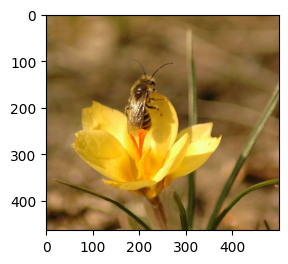

In [59]:
label_dict = {0:'Ant', 1:'Bee'}
print(label_dict[scoring_res.argmax()])      # ラベルに変換して結果を返す

plt.figure(figsize=(3, 3))
plt.imshow( Image.open(os.path.join(image_path, sample_img)))
plt.show()